In [3]:
import numpy as np
import pickle, sys, os, glob, scipy
from scipy.optimize import minimize
from scipy.stats import norm
from itertools import accumulate
from matplotlib import pyplot as plt

In [4]:
nb_subj, nb_sessions, nb_runs = 25, 2, 3
files           = glob.glob('data/td_volnoise_subj_*')
subject_indexes = np.array([np.all(['data/td_volnoise_subj_{2}_run_{0}_session_{1}.pkl'.format(i,j,k) in files for i in range(3) for j in range(2)]) * k for k in range(1,nb_subj + 1)])
subject_indexes = subject_indexes[subject_indexes != 0]
subject_indexes = np.delete(subject_indexes, 5)
nb_subj         = len(subject_indexes)

IndexError: index 5 is out of bounds for axis 0 with size 0

In [290]:
##Fitting

In [291]:
idx_subj = 12
idx_session, idx_run = 0, 0
data_path = 'data/td_volnoise_subj_{}_run_{}_session_{}.pkl'.format(subject_indexes[idx_subj], idx_run, idx_session)
data = pickle.load(open(data_path, 'rb'), encoding="latin1")
actions = np.array(data['A_chosen'][:100], dtype=np.object); actions[actions==0] = "A"; actions[actions==1] = "B"
rewards = data['reward'][:100]

In [292]:
def negLogLikelihood_m1(beta, *args):
    if len(args) != 2: assert(False), 'InputError'
    actions, rewards = args
    countA = np.cumsum((actions == "A") * rewards + (actions == "B") * (1 - rewards))
    countB = np.cumsum((actions == "B") * rewards + (actions == "A") * (1 - rewards))
    counts = np.vstack((countA, countB))
    counts_chosen = counts[(actions=="B")*1, np.arange(len(actions))]
    counts_unchosen = counts[(actions=="A")*1, np.arange(len(actions))]
    return -np.sum(np.log(np.exp(beta * counts_chosen)/(np.exp(beta * counts_chosen) + np.exp(beta * counts_unchosen))))

def negLogLikelihood_m2(parameters, *args):
    if len(args) != 2: assert(False), 'InputError'
    actions, rewards = args        
    alpha, beta = parameters
    correctA = np.concatenate((np.array([0.5]), (actions == "A") * rewards + (actions == "B") * (1 - rewards)))
    correctB = np.concatenate((np.array([0.5]), (actions == "B") * rewards + (actions == "A") * (1 - rewards)))
    pA = np.array(list(accumulate(correctA, lambda x, y: (1 - alpha) * x + alpha * y)))[:-1]
    pB = np.array(list(accumulate(correctB, lambda x, y: (1 - alpha) * x + alpha * y)))[:-1]
    probabilities = np.vstack((pA, pB))
    prob_chosen = probabilities[(actions=="B")*1, np.arange(len(actions))]
    prob_unchosen = probabilities[(actions=="A")*1, np.arange(len(actions))]
    return -np.sum(np.log(np.exp(beta * prob_chosen)/(np.exp(beta * prob_chosen) + np.exp(beta * prob_unchosen))))

In [293]:
res = minimize(negLogLikelihood_m1, [1], args=(actions, rewards), method='Nelder-Mead', tol=1e-6)
beta_1 = res.x
print('Model M1')
print('ML parameters are : {}'.format(res.x))
print('ML is : {}'.format(-res.fun))
print('')
res = minimize(negLogLikelihood_m2, [0.5, 1], args=(actions, rewards), method='Nelder-Mead', tol=1e-6)
alpha_2, beta_2 = res.x
print('Model M2')
print('ML parameters are : {}'.format(res.x))
print('ML is : {}'.format(-res.fun))

Model M1
ML parameters are : [0.04159851]
ML is : -67.33884977150736

Model M2
ML parameters are : [0.52523842 2.20563001]
ML is : -46.777493927847146


In [148]:
##Selection

In [153]:
idx_session, idx_run = 0, 2
data_path = 'data/td_volnoise_subj_{}_run_{}_session_{}.pkl'.format(subject_indexes[idx_subj], idx_run, idx_session)
data = pickle.load(open(data_path, 'rb'), encoding="latin1")
actions = np.array(data['A_chosen'][:100], dtype=np.object); actions[actions==0] = "A"; actions[actions==1] = "B"
rewards = data['reward'][:100]

In [154]:
print('Likelihood of M1 on held-out session : {}'.format(-negLogLikelihood_m1(beta_1, actions, rewards)))
print('Likelihood of M2 on held-out session : {}'.format(-negLogLikelihood_m2([alpha_2, beta_2], actions, rewards)))

Likelihood of M1 on held-out session : -68.28891543790496
Likelihood of M2 on held-out session : -72.17110518390933


In [159]:
str(actions).replace('\' \'', ', ')

"['A, A, A, B, A, A, A, B, A, A, A, B, B, B, A, A, B, B'\n 'A, B, A, A, B, A, A, B, A, A, A, A, A, A, B, B, B, B'\n 'B, A, B, B, A, A, A, B, B, B, B, A, A, A, A, B, B, B'\n 'A, B, A, A, A, A, A, A, A, A, B, B, A, A, B, A, B, A'\n 'A, A, A, A, A, B, B, B, A, B, B, B, A, A, B, A, A, B'\n 'B, B, B, A, B, B, B, A, A, A']"

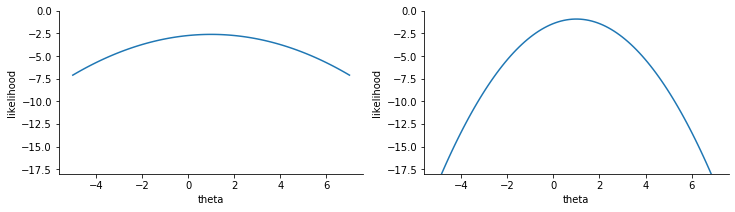

In [198]:
mu = 1
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
sigma = 2
x = np.linspace(-5, 7, 100)
plt.plot(x, np.log(norm.pdf(x, mu, sigma)) - 1)
plt.xlabel('theta')
plt.ylabel('likelihood')
plt.gca().set_ylim(-18, 0)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
plt.subplot(1, 2, 2)
sigma = 1
x = np.linspace(-5, 7, 100)
plt.plot(x, np.log(norm.pdf(x, mu, sigma)))
plt.gca().set_ylim(-18, 0)
plt.xlabel('theta')
plt.ylabel('likelihood')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
#plt.savefig('uniformative_parameter.pdf')

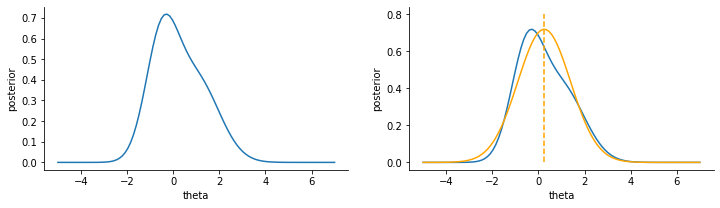

In [241]:
mu = -.5
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
sigma = 0.7
x = np.linspace(-5, 7, 100)
pdf = norm.pdf(x, mu, sigma) + norm.pdf(x, 1, 1)
mean = np.sum((x * pdf)/sum(pdf))
std_ = np.sqrt(np.sum(((x - mean)**2)*pdf/sum(pdf)))
plt.plot(x, pdf)
plt.xlabel('theta')
plt.ylabel('posterior')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
plt.subplot(1, 2, 2)
plt.plot(x, pdf)
plt.plot(x, norm.pdf(x, mean, std_) * max(pdf)/max(norm.pdf(x, mean, std_)), color='orange')
plt.plot([mean, mean], [0, 0.8], '--', color='orange')
plt.xlabel('theta')
plt.ylabel('posterior')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
plt.savefig('variational.pdf')

In [262]:
likelihood_m1 = lambda l, actions, rewards: np.exp(-negLogLikelihood_m1(l, actions, rewards))
likelihood_m2 = lambda l, actions, rewards: np.exp(-negLogLikelihood_m2(l, actions, rewards))

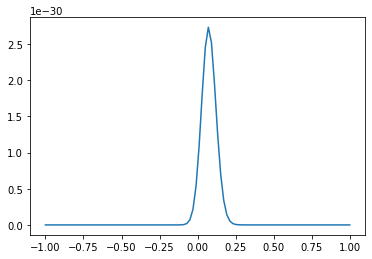

In [263]:
range_ = np.linspace(-1, 1, 100)
curve = np.array([likelihood_m1(r, actions, rewards) for r in range_])
plt.plot(range_, curve)

In [288]:
print('marginal likelihood for m1')
samples = np.random.rand(1000) * 2 - 1
marglkd1 = np.log(np.mean(np.array([likelihood_m1(s, actions, rewards) for s in samples]))) - np.log(len(samples))
print('margLkd : {}'.format(marglkd1))
print('')
print('marginal likelihood for m2')
samples = np.array([np.random.rand(1000), np.random.rand(1000) * 20 - 10])
marglkd2 = np.log(np.mean(np.array([likelihood_m2(s, actions, rewards) for s in samples.T]))) - np.log(len(samples.T))
print('margLkd : {}'.format(marglkd2))

marginal likelihood for m1
margLkd : -77.79875383972255

marginal likelihood for m2
margLkd : -74.73973292338768


In [286]:
print('marginal likelihood for m1')
samples = np.random.rand(1000) * 2 - 1
marglkd1 = np.mean(np.array([likelihood_m1(s, actions, rewards) for s in samples])) - np.log(len(samples))
print('margLkd : {}'.format(marglkd1))
print('')

marginal likelihood for m1
margLkd : -6.907755278982137



In [287]:
np.mean(np.array([likelihood_m1(s, actions, rewards) for s in samples]))

1.3699765153952185e-31